<a href="https://colab.research.google.com/github/Akhilez/ml_gallery/blob/master/ml_py/MLGallery/selective_generator/colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Selective GAN

```
Structure:

        noise + one-hot-class   (b, 10)
                 |
             Generator
                 |
               Image            (b, 1, 28, 28)
        _________|________
        |                |
     Softmax           Logistic
    Classifier        Discriminator
    (b, 10)             (b, 2)

```

Link to file: https://github.com/Akhilez/ml_gallery/blob/master/ml_py/MLGallery/selective_generator/colab.ipynb

In [0]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from torch.nn.functional import dropout, leaky_relu, binary_cross_entropy, softmax
from torch import sigmoid, tanh
from torch.nn import Conv2d, Linear, ConvTranspose2d

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
data_path = "./data/mnist/"

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(data_path, train=True, download=True,
                               transform=torchvision.transforms.ToTensor()), shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(data_path, train=False, download=True,
                               transform=torchvision.transforms.ToTensor()), shuffle=True)

Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw


Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw


Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw




Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw
Processing...
Done!


In [0]:
def to_one_hot(x):
    b = np.zeros((len(x), 10), dtype=np.float32)
    b[np.arange(len(x)), x] = 1
    return b

In [6]:
x_test = []
y_test = []

for data in test_loader:
    x_test.append(data[0].reshape(1, 28, 28).numpy())
    y_test.append(data[1][0])

y_test = torch.Tensor(to_one_hot(y_test))
x_test = torch.Tensor(x_test)

In [0]:
x_train = []
y_train = []

for data in train_loader:
    x_train.append(data[0].reshape(1, 28, 28).numpy())
    y_train.append(data[1][0])

y_train = torch.Tensor(to_one_hot(y_train))
x_train = torch.Tensor(x_train)

In [0]:
x_train = x_train[:5000].to(device)
x_test = x_test[:500].to(device)
y_train = y_train[:5000]
y_test = y_test[:500]

In [9]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

print(torch.min(x_test))
print(torch.max(x_test))

print(y_train[0])

torch.Size([5000, 1, 28, 28]) torch.Size([500, 1, 28, 28]) torch.Size([5000, 10]) torch.Size([500, 10])
tensor(0., device='cuda:0')
tensor(1., device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])


In [0]:
def plot_image(x):
    plt.imshow(x, cmap='gray')
    plt.show()

In [11]:
index = 13
plot_image(x_test[index].numpy().reshape((28, 28)))
print(y_test[index])

TypeError: ignored

In [0]:
def get_random(shape, min_=-0.5, max_=0.5):
    return torch.FloatTensor(*shape).uniform_(min_, max_).requires_grad_()

In [0]:
class Generator(torch.nn.Module):

    input_shape = (10)

    def __init__(self):
        super().__init__()

        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
        # torch.nn.Linear(in_features, out_features, bias=True)
        # torch.nn.functional.leaky_relu(input, negative_slope=0.01, inplace=False) → Tensor
        # torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1, padding_mode='zeros')

        self.fc1 = Linear(Generator.input_shape, 128 * 7 * 7)
        self.conv1 = ConvTranspose2d(128, 128, 4, stride=2, padding=1)  # [2, 128, 14, 14]
        self.conv2 = ConvTranspose2d(128, 128, 4, stride=2, padding=1)  # [2, 128, 28, 28]
        self.conv3 = ConvTranspose2d(128, 1, 7, padding=3)

    
    def forward(self, x, **kwargs):
        # x.shape = (batch, 100)

        h1 = leaky_relu(self.fc1(x))
        h1 = h1.reshape(-1, 128, 7, 7)
        h2 = leaky_relu(self.conv1(h1))
        h3 = leaky_relu(self.conv2(h2))
        h4 = tanh(self.conv3(h3))
        return h4


    def get_parameters(self):
        return [{'params': layer.parameters()} for layer in (self.fc1, self.conv1, self.conv2, self.conv3)]

    @staticmethod
    def getGeneratorInput2(y, batch_size):
        gen_input = torch.randn((batch_size, 100)).to(device)
        for batch in range(batch_size):
            for i in range(0, 10, 20):
                gen_input[batch][i: i+10] = y[batch]
        return gen_input

    @staticmethod
    def getGeneratorInput(y, batch_size):
        gen_input = torch.randn((batch_size, 10)).to(device) * 0.1
        gen_input = gen_input + y
        return gen_input

In [62]:
y_sample = y_test[10:12].to(device)
print(y_sample)
Generator.getGeneratorInput(y_sample, 2)

tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')


tensor([[-0.0024,  0.1117,  0.0676,  1.0121,  0.0054,  0.1922, -0.0143, -0.0433,
         -0.1206, -0.0404],
        [ 0.0126,  1.0127, -0.0595,  0.1062,  0.0762, -0.0236, -0.0311, -0.1109,
          0.0643,  0.0342]], device='cuda:0')

In [0]:
class FeatureExtractor(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.w1, self.b1 = get_random((784, 600)), torch.zeros(600, requires_grad=True)
        self.w2, self.b2 = get_random((600, 600)), torch.zeros(600, requires_grad=True)
        self.w3, self.b3 = get_random((600, 100)), torch.zeros(100, requires_grad=True)
    
    def forward(self, x, **kwargs):
        h1 = sigmoid(x.matmul(self.w1) + self.b1)
        h2 = sigmoid(h1.matmul(self.w2) + self.b2)
        h3 = sigmoid(h2.matmul(self.w3) + self.b3)
        return h3
    
    def optimize(self, lr):
        
        self.w1 = (self.w1 - lr * self.w1.grad).detach().requires_grad_()
        self.w2 = (self.w2 - lr * self.w2.grad).detach().requires_grad_()
        self.w3 = (self.w3 - lr * self.w3.grad).detach().requires_grad_()
        
        self.b1 = (self.b1 - lr * self.b1.grad).detach().requires_grad_()
        self.b2 = (self.b2 - lr * self.b2.grad).detach().requires_grad_()
        self.b3 = (self.b3 - lr * self.b3.grad).detach().requires_grad_()

In [0]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = Conv2d(1, 64, 3, stride=2, padding=1)
        self.conv2 = Conv2d(64, 64, 3, stride=2, padding=1)
        self.fc1 = Linear(3136, 2)

    
    def forward(self, x, **kwargs):

        h1 = dropout(leaky_relu(self.conv1(x)))  # TODO: Add dropout
        h2 = dropout(leaky_relu(self.conv2(h1)))
        h2 = h2.reshape(h2.shape[0], -1)  # Flatten
        h3 = softmax(self.fc1(h2))
        return h3


    def get_parameters(self):
        return [{'params': layer.parameters()} for layer in (self.conv1, self.conv2, self.fc1)]

    @staticmethod
    def generate_labels(sample_size, real=True):
        labels = torch.zeros((sample_size, 2))
        for sample in labels:
            sample[0] = 1 if real else 0
            sample[1] = 0 if real else 1
        return labels

In [21]:
Discriminator.generate_labels(2, real=False)

tensor([[0., 1.],
        [0., 1.]])

In [0]:
class Classifier (torch.nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = Conv2d(1, 28, 3, padding=1)
        self.fc1 = Linear(28 * 28 * 28, 128)
        self.fc2 = Linear(128, 10)

    def forward(self, x):
        h1 = torch.relu(self.conv1(x))
        h1 = h1.reshape(h1.shape[0], -1)  # flatten
        h2 = torch.sigmoid(self.fc1(h1))
        h3 = torch.nn.functional.softmax(self.fc2(h2))
        return h3

    def get_parameters(self):
        return [layer.parameters() for layer in (self.conv1, self.fc1, self.fc2)]

In [0]:
# fe = FeatureExtractor()
classifier = Classifier().to(device)
discriminator = Discriminator().to(device)
generator = Generator().to(device)

d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)
c_optimizer = torch.optim.Adam(classifier.parameters(), lr=0.0002)

In [0]:
batch_size = 200

real = Discriminator.generate_labels(batch_size).to(device)
fake = Discriminator.generate_labels(batch_size, real=False).to(device)

In [0]:
def train_c(x_batch, y_batch):

    c_optimizer.zero_grad()
    
    c_out = classifier(x_batch)
    
    loss = binary_cross_entropy(c_out, y_batch)

    loss.backward()
    c_optimizer.step()

    return loss.data.item()

In [0]:
def train_d(x_batch, y_batch):

    d_optimizer.zero_grad()
    
    # ------------ Train with real image ----------------
    
    discriminator_out = discriminator(x_batch)
    
    loss_discriminator_real = binary_cross_entropy(discriminator_out, real)

    # --------------- Train with fake image -------------------

    generator_input = Generator.getGeneratorInput(y_batch, batch_size).to(device)
    
    generated = generator(generator_input)
    discriminator_out = discriminator(generated)
    
    loss_discriminator = binary_cross_entropy(discriminator_out, fake)
    
    # ---------------- Optimize --------------------

    loss = loss_discriminator_real + loss_discriminator

    loss.backward()
    d_optimizer.step()

    return loss_discriminator_real.data.item(), loss_discriminator.data.item()

In [0]:
def train_g(x_batch, y_batch):

    generator_input = Generator.getGeneratorInput(y_batch, batch_size).to(device)

    g_optimizer.zero_grad()
    
    generated = generator(generator_input)
    discriminator_out = discriminator(generated)
    classifier_out = classifier(generated)

    loss_generator = binary_cross_entropy(discriminator_out, real)
    loss_classifier = binary_cross_entropy(classifier_out, y_batch)

    loss = loss_generator + 2 * loss_classifier
    
    loss.backward()
    g_optimizer.step()

    return loss.data.item()

In [ ]:
epochs = 5
for epoch in range(epochs):
    print(f'Epoch: {epoch}')
    losses = {'c': 0, 'dr': 0, 'df': 0, 'g': 0}

    for i in range(0, len(x_train), batch_size):
        start_index = i
        end_index = i+batch_size
        
        x_batch = x_train[start_index:end_index]
        y_batch = y_train[start_index:end_index].to(device)
        
        loss_c = train_c(x_batch, y_batch)
        loss_d1, loss_d2 = train_d(x_batch, y_batch)
        loss_g = train_g(x_batch, y_batch)

        losses['c'] += loss_c
        losses['dr'] += loss_d1
        losses['df'] += loss_d2
        losses['g'] += loss_g

    print(f'    Losses: {losses}')

In [ ]:
with torch.no_grad():
    
    index = 33
    sample_size = 10
    
    x_sample = x_test[index:index+sample_size].to(device)
    y_sample = torch.tensor(to_one_hot(range(10))).to(device)

    generator_input = Generator.getGeneratorInput(y_sample, sample_size).to(device)

    generated = generator(generator_input)
    discriminator_out = discriminator(generated)
    classifier_out = classifier(x_sample)
    
    real_discriminator_out = discriminator(x_sample)
    
    for i in range(sample_size):
        plot_image(generated[i].reshape((28, 28)).cpu())
        plt.show()
        # plot_image(x_sample[i].reshape((28, 28)).cpu())
        # plt.show()
        
    
    print(f"Discriminator_out fake: {discriminator_out}\nReal Img Discriminator Out: {real_discriminator_out}")
    print(f"\nClass: {torch.max(classifier_out, 1)[1]}\nReal class: {torch.max(y_sample, 1)[1]}")

In [77]:
with torch.no_grad():
    
    index = 33
    sample_size = 10
    
    x_sample = x_test[index:index+sample_size].to(device)
    y_sample = torch.tensor(to_one_hot(range(10))).to(device)

    generator_input = Generator.getGeneratorInput(y_sample, sample_size).to(device)

    generated = generator(generator_input)
    discriminator_out = discriminator(generated)
    classifier_out = classifier(x_sample)
    
    real_discriminator_out = discriminator(x_sample)
    
    for i in range(sample_size):
        plot_image(generated[i].reshape((28, 28)).cpu())
        plt.show()
        # plot_image(x_sample[i].reshape((28, 28)).cpu())
        # plt.show()
        
    
    print(f"Discriminator_out fake: {discriminator_out}\nReal Img Discriminator Out: {real_discriminator_out}")
    print(f"\nClass: {torch.max(classifier_out, 1)[1]}\nReal class: {torch.max(y_sample, 1)[1]}")

Epoch: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


    Losses: {'c': 2.0004075542092323, 'dr': 17.18263566493988, 'df': 15.814942002296448, 'g': 22.00268930196762}
Epoch: 1
    Losses: {'c': 1.86631765589118, 'dr': 15.756132394075394, 'df': 12.534117877483368, 'g': 33.7882844209671}
Epoch: 2
    Losses: {'c': 1.7511283829808235, 'dr': 16.200819492340088, 'df': 19.1485515832901, 'g': 21.132915675640106}
Epoch: 3
    Losses: {'c': 1.6507772766053677, 'dr': 16.50431028008461, 'df': 16.614192128181458, 'g': 20.84721541404724}
Epoch: 4
    Losses: {'c': 1.5623045191168785, 'dr': 16.188466131687164, 'df': 16.433917820453644, 'g': 20.765638649463654}


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


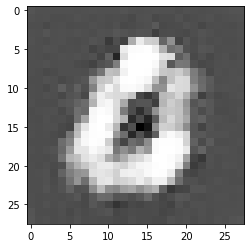

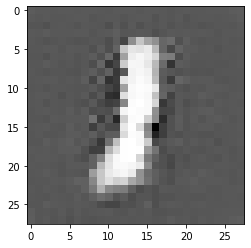

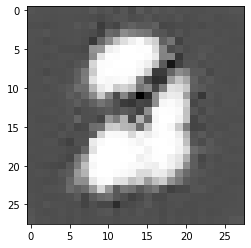

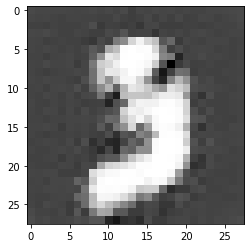

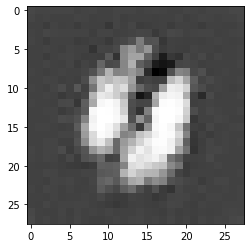

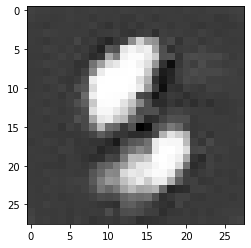

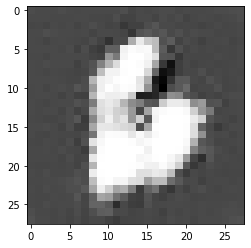

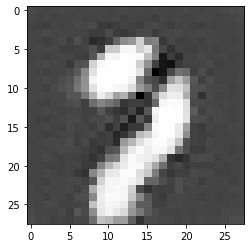

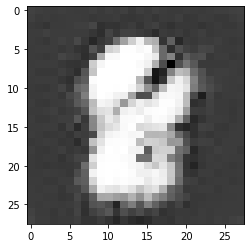

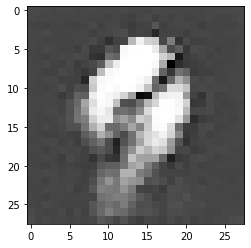

Discriminator_out fake: tensor([[0.4538, 0.5462],
        [0.4355, 0.5645],
        [0.4527, 0.5473],
        [0.3730, 0.6270],
        [0.3633, 0.6367],
        [0.5599, 0.4401],
        [0.4899, 0.5101],
        [0.6007, 0.3993],
        [0.5110, 0.4890],
        [0.2169, 0.7831]], device='cuda:0')
Real Img Discriminator Out: tensor([[0.5590, 0.4410],
        [0.5497, 0.4503],
        [0.5901, 0.4099],
        [0.4527, 0.5473],
        [0.5565, 0.4435],
        [0.4460, 0.5540],
        [0.6512, 0.3488],
        [0.6614, 0.3386],
        [0.2780, 0.7220],
        [0.4000, 0.6000]], device='cuda:0')

Class: tensor([2, 0, 1, 3, 7, 3, 9, 3, 6, 6], device='cuda:0')
Real class: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0')


In [83]:
with torch.no_grad():
    
    index = 33
    sample_size = 10
    
    x_sample = x_test[index:index+sample_size].to(device)
    y_sample = torch.tensor(to_one_hot(range(10))).to(device)

    generator_input = Generator.getGeneratorInput(y_sample, sample_size).to(device)

    generated = generator(generator_input)
    discriminator_out = discriminator(generated)
    classifier_out = classifier(x_sample)
    
    real_discriminator_out = discriminator(x_sample)
    
    for i in range(sample_size):
        plot_image(generated[i].reshape((28, 28)).cpu())
        plt.show()
        # plot_image(x_sample[i].reshape((28, 28)).cpu())
        # plt.show()
        
    
    print(f"Discriminator_out fake: {discriminator_out}\nReal Img Discriminator Out: {real_discriminator_out}")
    print(f"\nClass: {torch.max(classifier_out, 1)[1]}\nReal class: {torch.max(y_sample, 1)[1]}")